In [40]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from corner import corner
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import cohen_kappa_score, f1_score

from WISE_tools import plot_confusion_matrix, plot_completeness_contamination

In [41]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'CommonName_y', 'Class',
        'CoarseClass', 'IsBinary', 'WISE_Designation_x', 'N_obs', 'W1chi2',
        'W1chi2red', 'W1_MAD', 'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD',
        'W2_EWM', 'W1-W2chi2', 'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM',
        'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
        'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt', 'W1-W2_Nzeroes', 'W1-W2_meanDt',


In [42]:
training_indices = np.array([c not in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

In [43]:
#training data
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W1_EWM','W1_Nzeroes',
                   'W1_meanDt', 'W1_stdDt','W2chi2red','W2_EWM','W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2chi2red','W1-W2_EWM','W1-W2_Nzeroes','W1-W2_meanDt','W1-W2_stdDt']]

y = training_data['Class'].values
y_c = training_data['CoarseClass'].values

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=0)


scaler=StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [49]:
"""rf_params = {'max_depth': [int(x) for x in np.linspace(10, 110, 11)]+[None],'n_estimators':np.arange(10,160,10),
         'max_features': ['sqrt','log2',None]}
svm_params = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]), "C":[0.01,0.1,1,10,100]}, 
              {"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11), "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]), 
               "C":[0.01,0.1,1,10,100]},
              {"kernel": ["linear"], "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]),"C":[0.01,0.1,1,10,100]}]
gp_params = {'kernel':['linear','rbf','sigmoid',None]}

rf = RandomForestClassifier()
svc = SVC(class_weight='balanced')
gp = GaussianProcessClassifier(n_jobs=-1)
best_estimators = []
from tqdm.notebook import tqdm
for clf,params in tqdm(zip([rf,svc,gp],[rf_params,svm_params,gp_params]),total=3):
    grid = GridSearchCV(clf, params, cv=5, n_jobs=-1, verbose=10, error_score=-1e10,scoring='f1_weighted')
    grid.fit(X_train_scale,y_train)
    best_estimators.append(grid.best_estimator_)
    
"""

'rf_params = {\'max_depth\': [int(x) for x in np.linspace(10, 110, 11)]+[None],\'n_estimators\':np.arange(10,160,10),\n         \'max_features\': [\'sqrt\',\'log2\',None]}\nsvm_params = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]), "C":[0.01,0.1,1,10,100]}, \n              {"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11), "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]), \n               "C":[0.01,0.1,1,10,100]},\n              {"kernel": ["linear"], "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]),"C":[0.01,0.1,1,10,100]}]\ngp_params = {\'kernel\':[\'linear\',\'rbf\',\'sigmoid\',None]}\n\nrf = RandomForestClassifier()\nsvc = SVC(class_weight=\'balanced\')\ngp = GaussianProcessClassifier(n_jobs=-1)\nbest_estimators = []\nfrom tqdm.notebook import tqdm\nfor clf,params in tqdm(zip([rf,svc,gp],[rf_params,svm_params,gp_params]),total=3):\n    grid = GridSearchCV(clf, params, cv=5, n_jobs=-1, verbose=10, error_score=-1e10,scor

In [68]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=80, max_depth=20, max_features='sqrt')
svc = SVC(class_weight='balanced', kernel='rbf', C=1, gamma = 1.0/X_train_scale.shape[1],probability=True)
gp = GaussianProcessClassifier(n_jobs=-1)

voter =  VotingClassifier(estimators=[('rf', rf), ('svm', svc), ('gp', gp)],
                         voting='soft')
voter.fit(X_train_scale,y_train)
y_check = voter.predict(X_test_scale)
voter

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=20,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=80,
                                                     n_jobs=None,
       

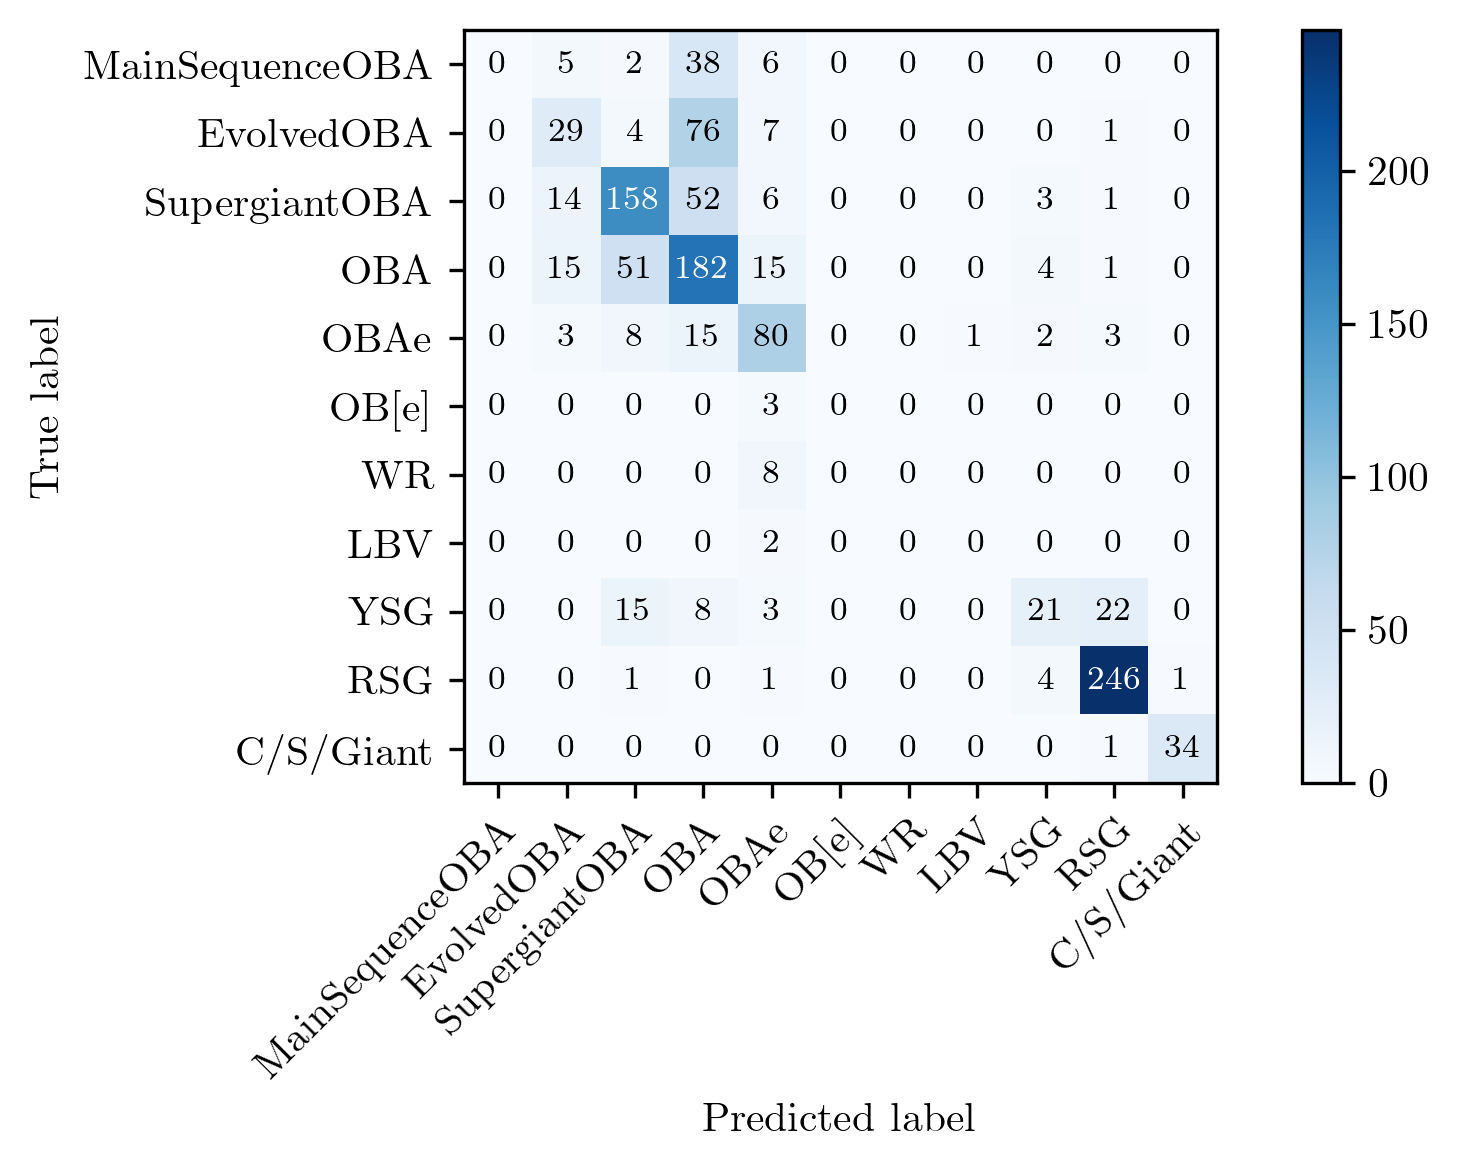

In [69]:
classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant']

fig,ax = plot_confusion_matrix(y_test, y_check, classes=classes, normalize=False);
fig.dpi = 300
ax.set_title('')
plt.tight_layout()
plt.savefig('../plots/raw_matrix_voter.pdf');

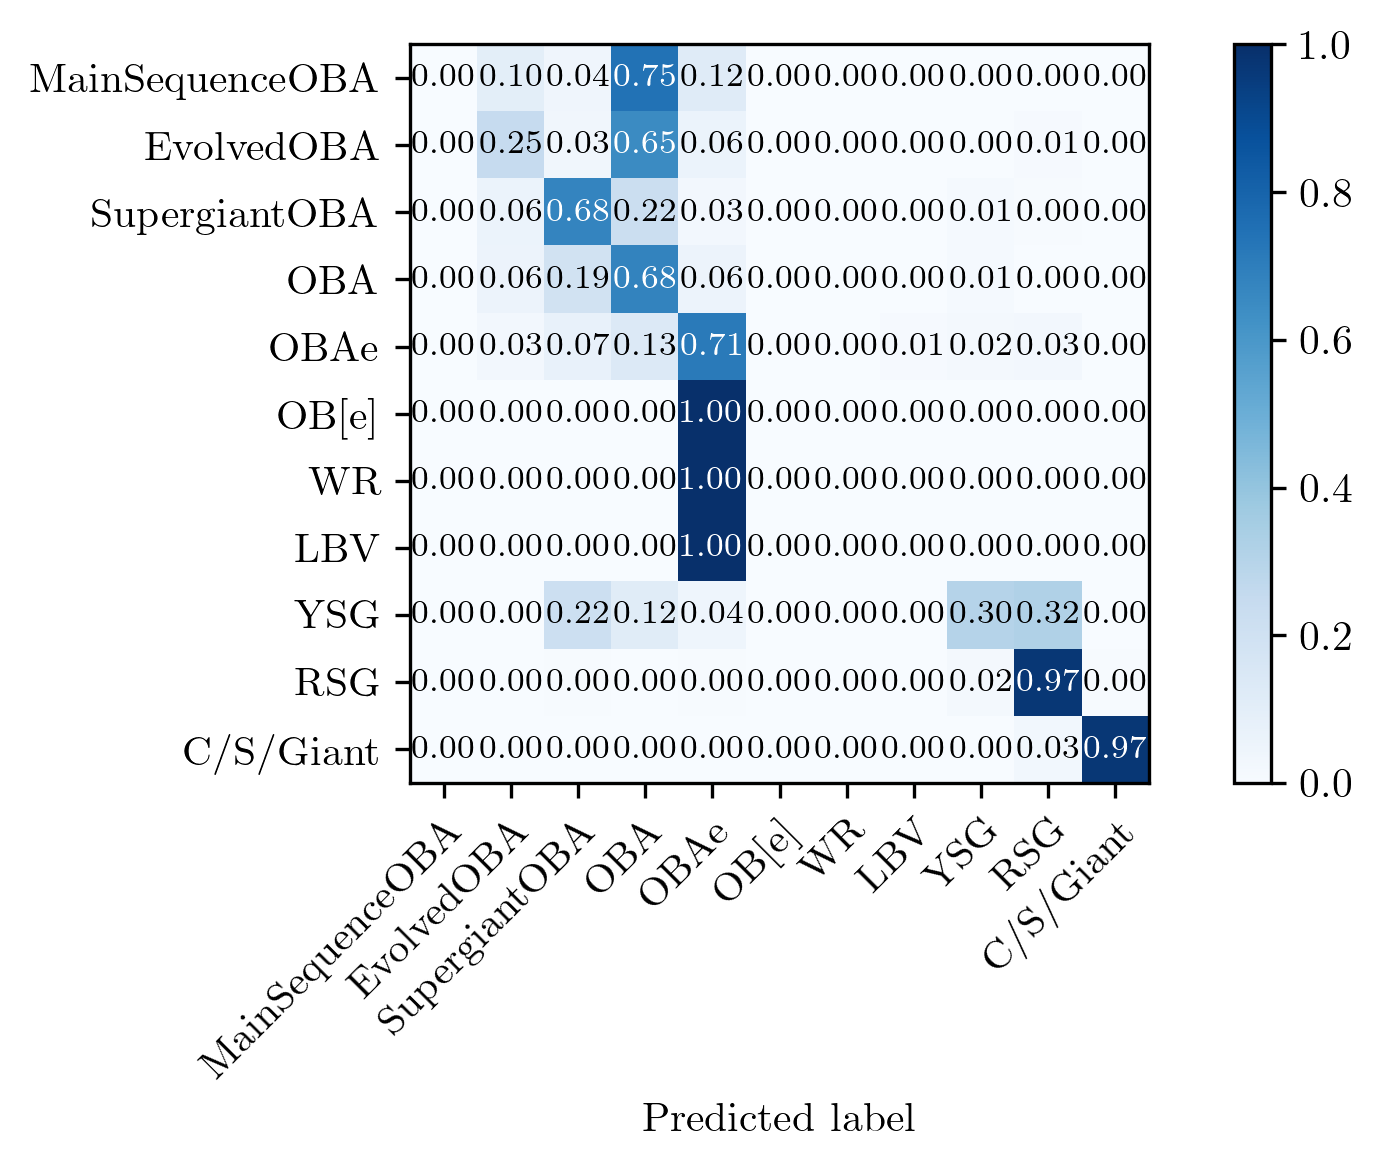

In [70]:
fig,ax = plot_confusion_matrix(y_test, y_check, classes=classes, normalize=True);
fig.dpi = 300
ax.set_title('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('../plots/confusion_voter.pdf');

/Users/carina/Research/UW/GaiaSprintMassive/WISE/code/WISE_tools.py:121: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=0)


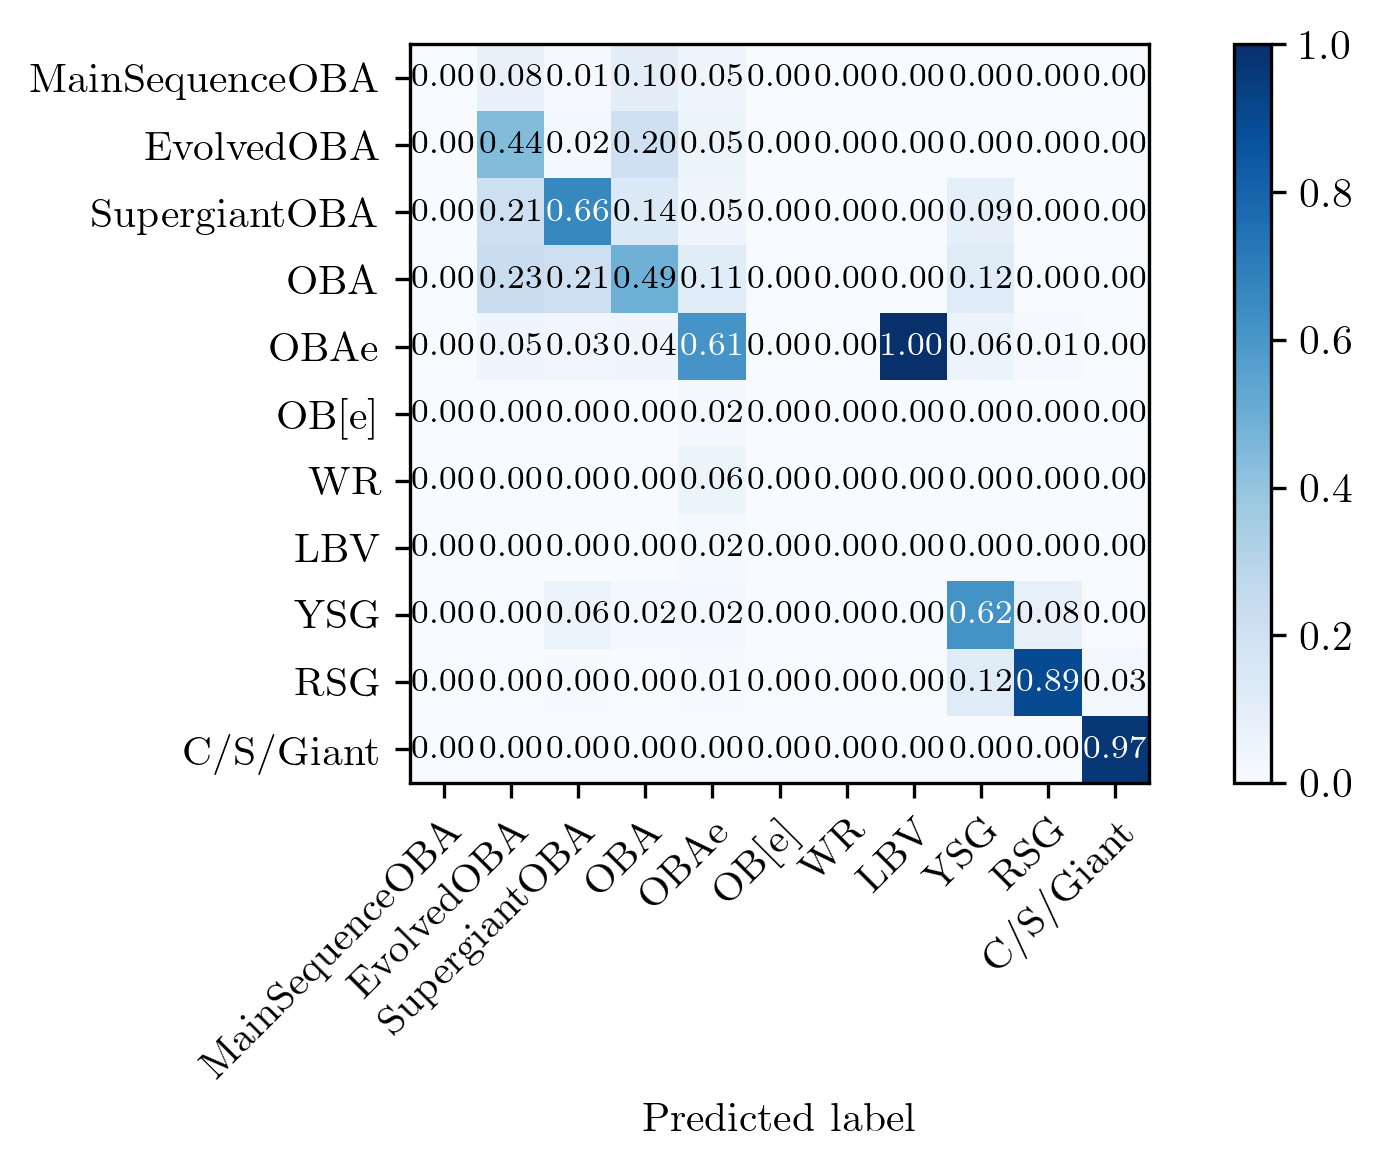

In [71]:
fig,ax = plot_confusion_matrix(y_test, y_check, classes=classes, normalize=True, normalize_axis=0);
fig.dpi = 300
ax.set_title('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('../plots/efficiency_voter.pdf');

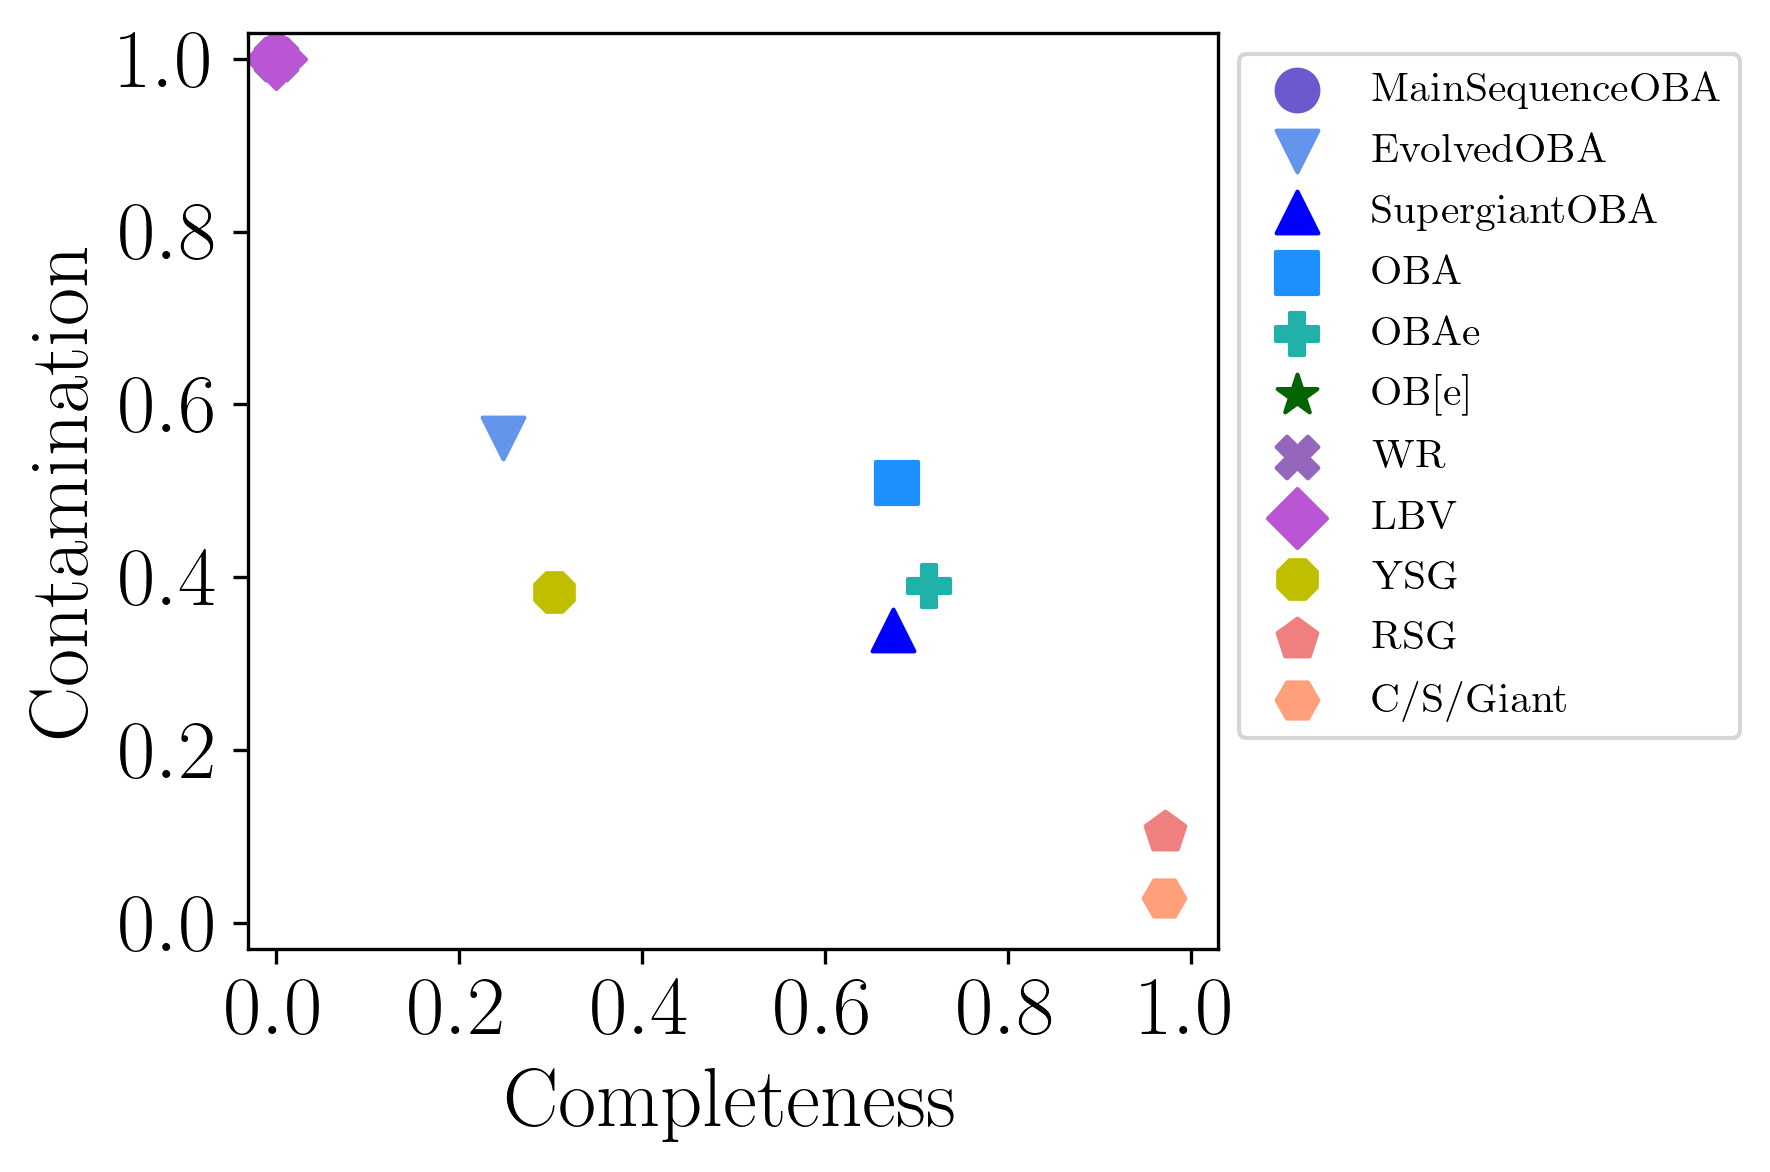

In [73]:
m_dict = {'MainSequenceOBA':'o','EvolvedOBA':'v','SupergiantOBA':'^','OBA':'s',
          'OBAe':'P','OB[e]':'*','WR':'X','LBV':'D','YSG':'8','RSG':'p','C/S/Giant':'H'}
c_dict = {'MainSequenceOBA':'slateblue','EvolvedOBA':'cornflowerblue','SupergiantOBA':'b',
          'OBA':'dodgerblue','OBAe':'lightseagreen','OB[e]':'darkgreen','WR':'C4',
          'LBV':'mediumorchid','YSG':'y','RSG':'lightcoral','C/S/Giant':'lightsalmon'}
fig,ax = plot_completeness_contamination(y_test, y_check, classes=classes,c_dict=c_dict,m_dict=m_dict,s=100)
fig.dpi=300
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlim(-0.03,1.03)
ax.set_ylim(-0.03,1.03)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
fig.tight_layout()
plt.savefig('../plots/completeness_contamination_voter.pdf', bbox_inches = "tight")

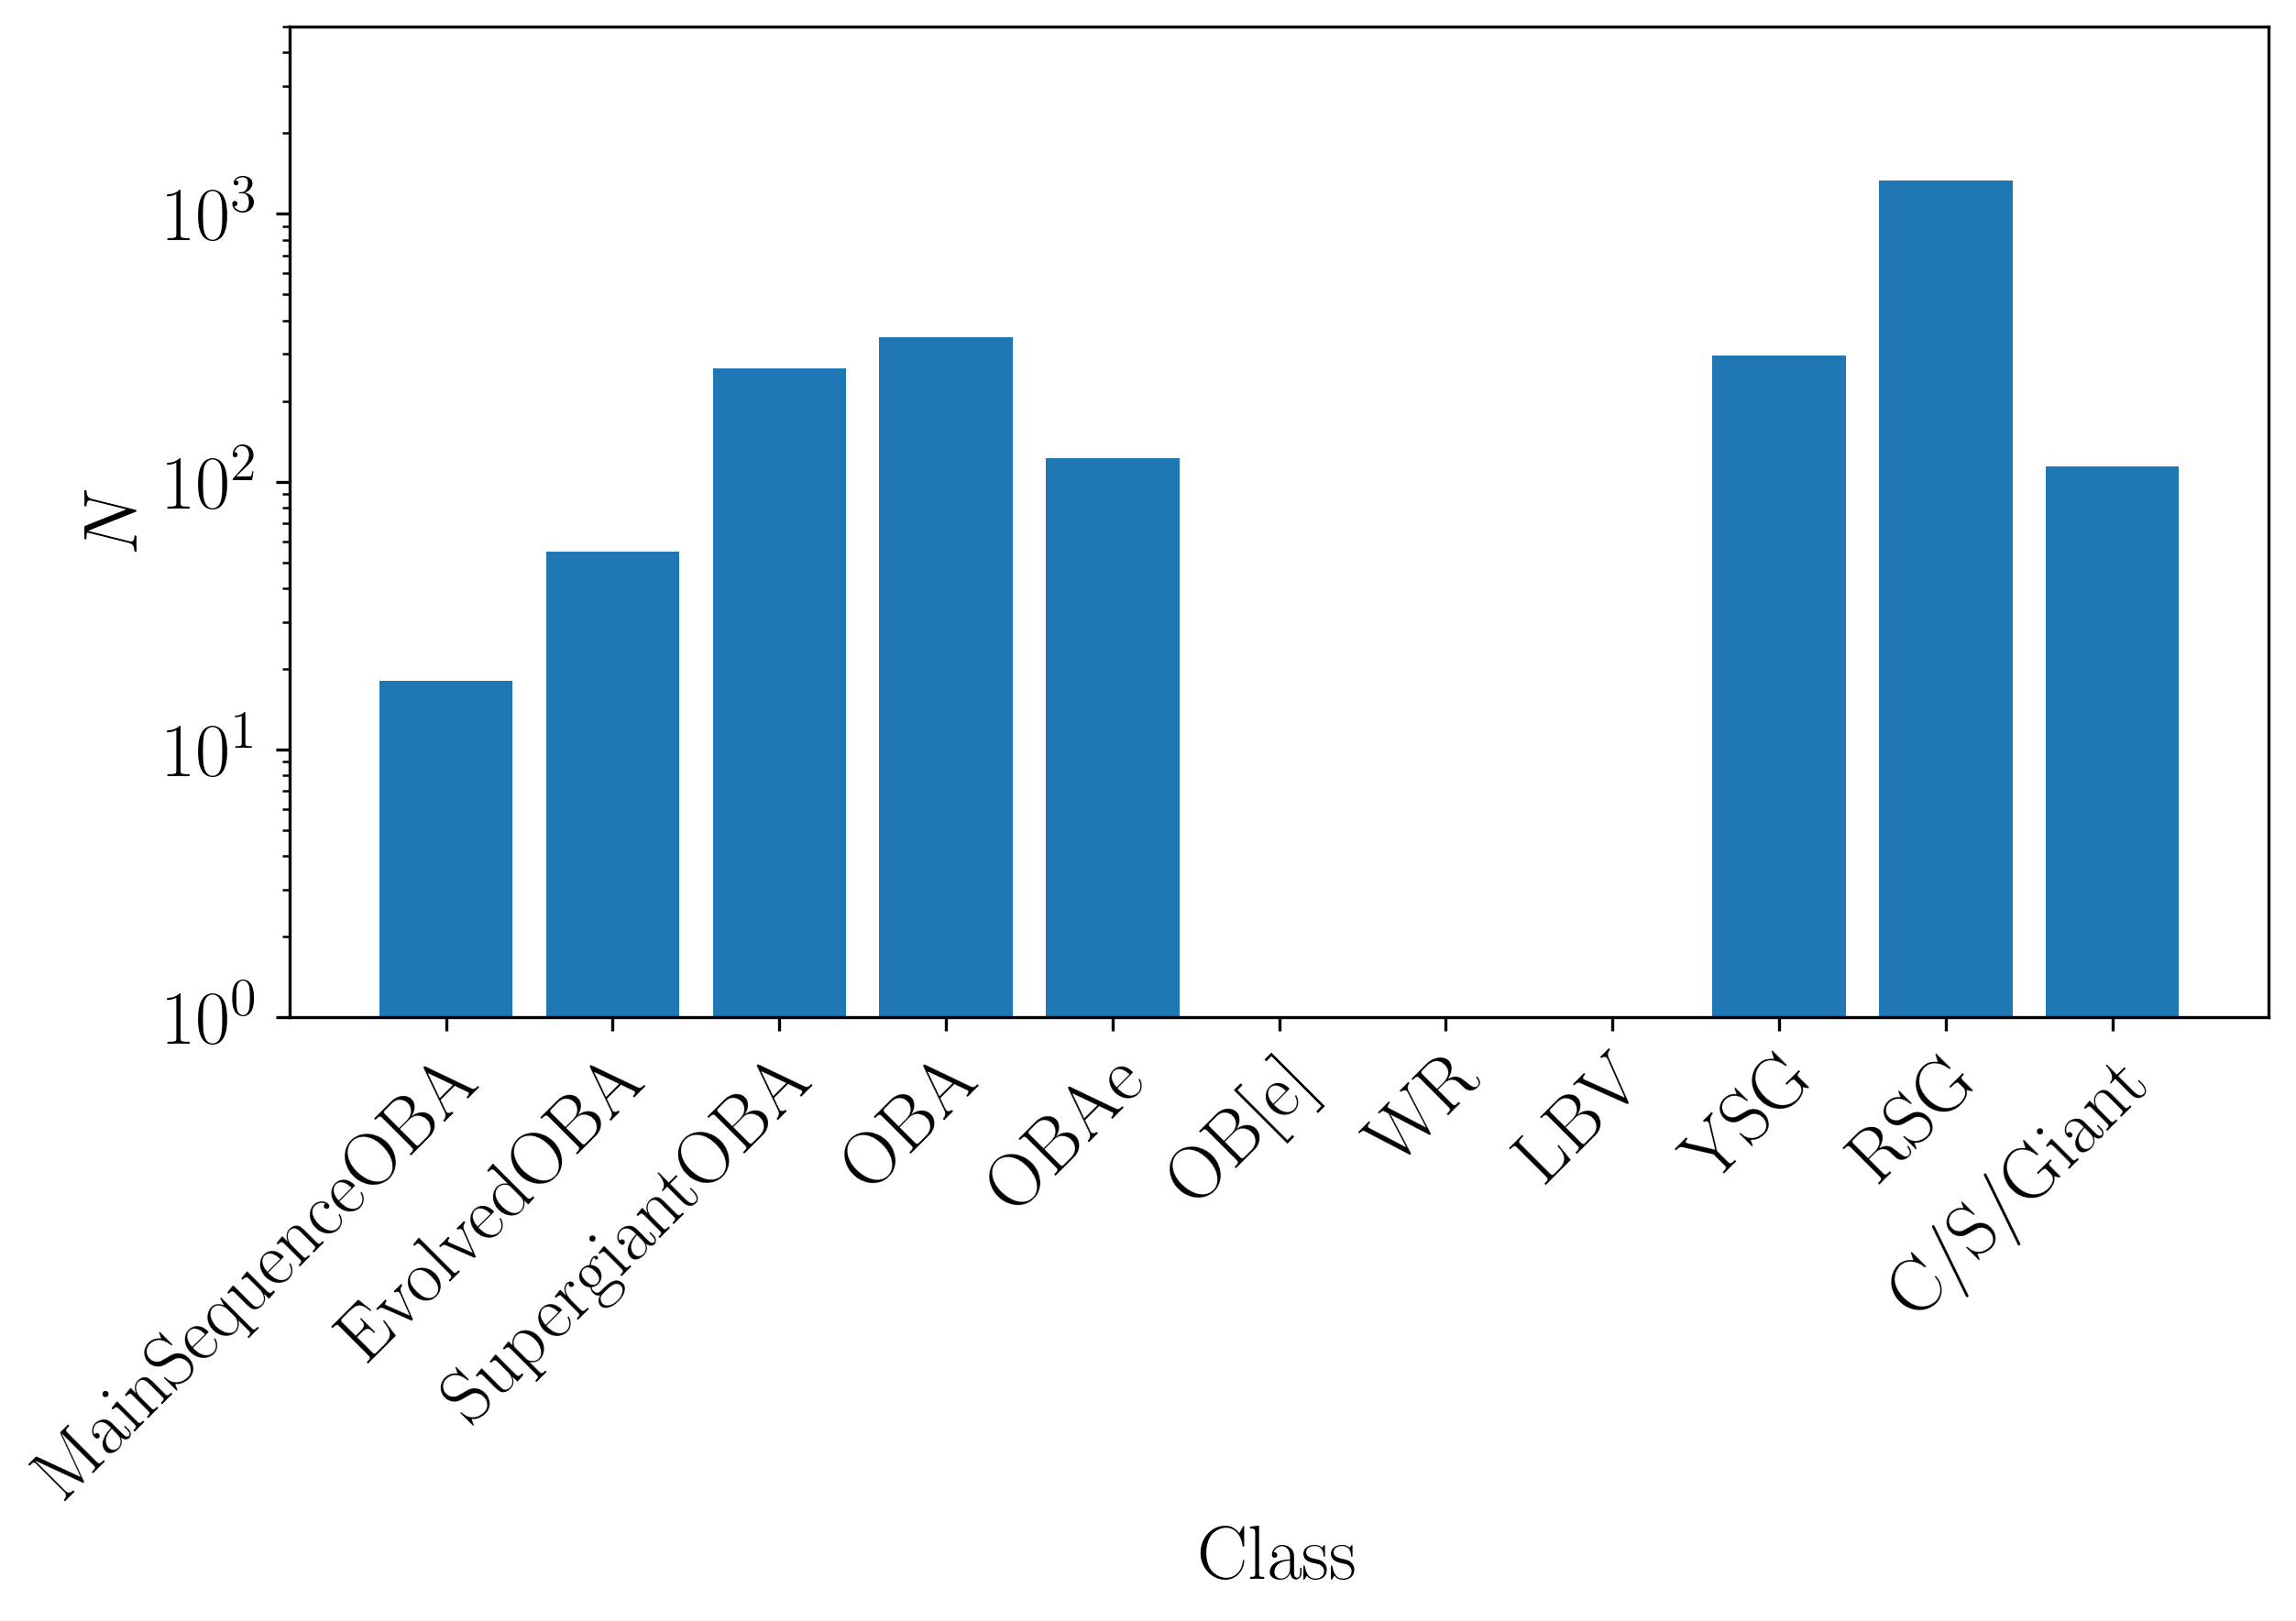

In [39]:
unknown_indices = [c in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class']]
unknowns = joined[unknown_indices].fillna(value=0).reset_index()
unknowns_data = unknowns[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W1_EWM','W1_Nzeroes',
                   'W1_meanDt', 'W1_stdDt','W2chi2red','W2_EWM','W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2chi2red','W1-W2_EWM','W1-W2_Nzeroes','W1-W2_meanDt','W1-W2_stdDt']]
X_unknown = scaler.transform(unknowns_data)
#refit on the whole data set
X_scale = scaler.transform(X)
voter.fit(X_scale, y)
unknown_classes = voter.predict(X_unknown)
num_output = []
for pred_class in classes:
    num = len(unknown_classes[unknown_classes == pred_class])
    num_output.append(num)
    
plt.figure(dpi=300,figsize=(8.5,6))
plt.bar(np.arange(len(classes)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(classes)),labels=classes,rotation=45,ha="right",
             rotation_mode="anchor")
plt.xlabel('Class',fontsize=20)
plt.ylabel('$N$',fontsize=20)
plt.ylim(1,5000)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
#plt.savefig('../plots/unknown_labels.pdf')